<a href="https://colab.research.google.com/github/d9ria/AB-Tests-Practice/blob/main/5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You work for a food delivery app. A colleague approached you with the results of two tests:

The first test was about the resolution of food images in the app: users were shown either rectangular images or new square images.
The second test involved updating the order button, where some users saw the old version while others saw the new one.
Your colleague wants your help. He looked at the graphs and suspected that there might be differences among the groups. Your task is to assist him in testing hypotheses, drawing conclusions based on statistical tests, and making decisions.

Tasks:

- Choose a method suitable for the first question.
- Check whether the variances within groups are homogeneous.
- Conduct a test for the normality of the distribution.
- Compare the means within the presented groups.
- Use the Tukey criterion to determine between which groups there are statistically significant differences.
- Make a decision: which images will be used in the end?
- Choose a method for the second test.
- Visualize the distribution of events for the control and test groups.
- Look at the descriptive statistics of events broken down by group and user segment.
- Choose a formula for the model, conduct the test.

Data Description:

5_task_1:

id - client ID in the experiment
group - image resolution display (A - 16:9 rectangular, B - square, C - 12:4 rectangular)
events - total number of dishes ordered over a period

5_task_2:

id - client ID in the experiment
segment - segment (high/low)
group - button view (control - old version, test - new version)
events - total number of dishes ordered over a period

In [3]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data_photo = pd.read_csv('5_task_1.csv')
data_photo.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [11]:
a_group = data_photo.query("group == 'A'")
b_group = data_photo.query("group == 'B'")
c_group = data_photo.query("group == 'C'")

In [15]:
 pg.homoscedasticity(data=data_photo, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


In [16]:
a_sample = data_photo[data_photo['group'] == 'A']['events'].sample(1000, random_state=17)
b_sample = data_photo[data_photo['group'] == 'B']['events'].sample(1000, random_state=17)
c_sample = data_photo[data_photo['group'] == 'C']['events'].sample(1000, random_state=17)

In [19]:
print(ss.shapiro(a_sample))
print(ss.shapiro(b_sample))
print(ss.shapiro(c_sample))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)
ShapiroResult(statistic=0.9980818629264832, pvalue=0.3186272084712982)
ShapiroResult(statistic=0.9981189966201782, pvalue=0.3360903561115265)


In [20]:
pg.anova(data=data_photo, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [21]:
pairwise_tukeyhsd(data_photo.events, data_photo.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.0,7.7038,8.3642,True
A,C,-2.1093,0.0,-2.4395,-1.7791,True
B,C,-10.1433,0.0,-10.4735,-9.8131,True


In [22]:
data_button = pd.read_csv('5_task_2.csv')
data_button.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [25]:
test_group = data_button.query("group == 'test'")
control_group = data_button.query("group == 'control'")

(<Axes: xlabel='events', ylabel='Count'>,
 <Axes: xlabel='events', ylabel='Count'>)

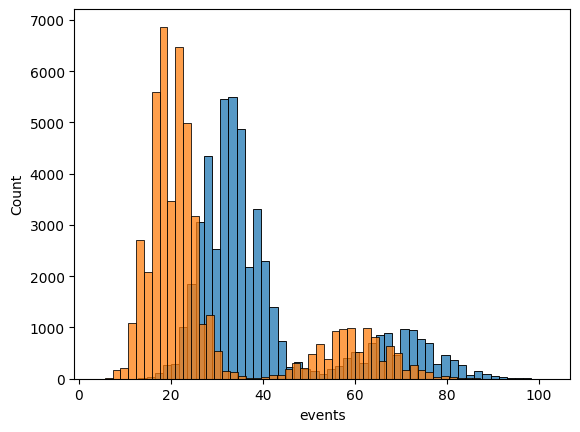

In [32]:
sns.histplot(test_group.events, bins=50), sns.histplot(control_group.events, bins=50)

In [36]:
test_group.groupby(['group','segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group segment                                                             
test  high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
      low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [37]:
control_group.groupby(['group','segment']).events.describe()

count       mean       std   min   25%   50%   75%   max
group   segment                                                            
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0  89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0  41.0

In [42]:
model_main = smf.ols("events ~ segment + group + segment:group", data=data_button).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [44]:
data_button['combination'] = data_button['group'] + ' \ ' + data_button['segment']
data_button.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high


In [45]:
pairwise_tukeyhsd(data_button.events, data_button.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.0,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.0,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.0,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.0,49.7388,50.075,True
control \ low,test \ low,12.9944,0.0,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.0,-37.0807,-36.7445,True


<Axes: xlabel='events', ylabel='group'>

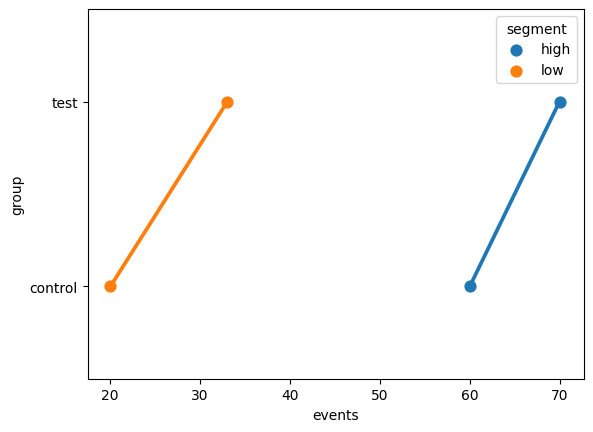

In [46]:
sns.pointplot(x="events", y="group", hue='segment', data=data_button)

The factor 'group' turned out to be statistically significant, the factor 'segment' is statistically significant, and their interaction is also significant. Judging by the graph, the mean value of events has INCREASED for all groups. Therefore, the decision is to ROLL OUT THE NEW VERSION.